In [2]:
library(dplyr)
library(readr)
library(repr)

# DATASET EXTRACTION

In [1]:
dataset_Auronzo <- read.csv("dataset/Auronzo.csv", header = FALSE, sep = ";")
head(dataset_Auronzo, n = 10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ARPAV Centro Meteorologico di Teolo,,,,,,,,,,,,,
2,,,,,,,,,,,,,,
3,Bollettino dei valori mensili pluriennali,,,,,,,,,,,,,
4,,,,,,,,,,,,,,
5,Stazione Auronzo,,,,,,,,,,,,,
6,Coordinata X 1762629 Gauss-Boaga fuso,,,,,,,,,,,,,
7,Coordinata Y 5161582 Ovest (EPSG:3003),,,,,,,,,,,,,
8,Quota della stazione 849 m s.l.m.,,,,,,,,,,,,,
9,Parametro Precipitazione (mm) somma,,,,,,,,,,,,,


In [6]:
extract_dataset <- function(directory, city_list) {
    
    convert_numbers <- function(x) {
      num <- suppressWarnings(as.numeric(x))
      ifelse(is.na(num) & !is.na(x), x, num)
    }
    
    dataset <- list()
    months <- c('GEN', 'FEB', 'MAR', 'APR', 'MAG', 'GIU', 'LUG', 'AGO', 'SET', 'OTT', 'NOV', 'DIC')
    
    for (city in city_list) {
        dataset_city <- read.csv(paste0(directory, "/", city, ".csv"), header = FALSE, sep = ";")
        
        extracted_ds <- list()
        
        for (n_line in 1:nrow(dataset_city)) {

            element = dataset_city[n_line, 1]

            if (startsWith(element, "Parametro")) {

                metric <- substr(element, nchar("Parametro ")+1, nchar(element))
                metric <- iconv(metric, from = "", to = "UTF-8", sub = "_")
                
                data_matrix <- as.matrix(sapply(dataset_city[(n_line + 5):(n_line + 35), 2:13], convert_numbers))
                skipped_days_matrix <- as.matrix(sapply(dataset_city[(n_line + 48):(n_line + 78), 2:13], convert_numbers))
                
                n_rows <- min(nrow(data_matrix), nrow(skipped_days_matrix))
                years <- 1994:(1994 + n_rows - 1)
                
                data_matrix <- data_matrix[1:n_rows, , drop = FALSE]
                skipped_days_matrix <- skipped_days_matrix[1:n_rows, , drop = FALSE]
                
                rownames(data_matrix) <- years
                rownames(skipped_days_matrix) <- years
                colnames(data_matrix) <- months[1:ncol(data_matrix)]
                colnames(skipped_days_matrix) <- months[1:ncol(skipped_days_matrix)]
                
                extracted_ds[[metric]] <- data_matrix
                extracted_ds[[paste0(metric, "_days")]] <- skipped_days_matrix
            }

        }
            
        dataset[[city]] <- extracted_ds
    }
        
    return(dataset)
}


In [7]:
stations_names <- c("Auronzo", "Porto_Tolle_-_Pradon", "Roverchiara", "Castelfranco_Veneto")

In [8]:
dataset <- extract_dataset("dataset", stations_names)

In [9]:
dataset

,GEN,FEB,MAR,APR,MAG,GIU,LUG,AGO,SET,OTT,NOV,DIC
1994,56.4,34.4,15.8,99.6,93.4,59.2,179.8,120.2,229.8,58.6,45.6,16.6
1995,37.8,45.2,43.4,50.2,146.4,172.4,134.4,74.4,138.6,0.0,15.0,68.2
1996,28.6,12.8,5.8,39.4,105.2,91.4,110.4,189.2,36.2,249.8,258.2,33.4
1997,51.2,4.2,11.2,27.6,68.2,247.0,145.8,109.4,53.4,3.2,197.0,107.6
1998,24.4,8.2,3.8,169.4,53.6,229.6,168.4,72.2,168.2,208.4,21.4,3.0
1999,57.6,9.2,111.8,100.8,118.8,135.8,142.2,154.6,125.0,116.0,46.4,43.2
2000,8.6,6.2,91.4,107.4,74.0,65.0,133.6,147.2,130.2,272.2,423.8,57.8
2001,187.4,12.6,154.0,123.4,46.0,90.0,146.4,163.0,141.0,36.0,38.2,0.0
2002,7.6,48.6,54.6,132.2,196.8,181.8,110.6,109.6,104.6,82.2,419.8,61.6
2003,21.4,2.4,3.0,60.4,82.2,134.4,105.8,110.8,17.8,155.8,256.2,71.4


In [12]:
#Printout the schema of the df
glimpse(dataset)

ERROR: Error in glimpse(dataset): could not find function "glimpse"


In [13]:
# Lista delle metriche del dataset

metrics_list <- names(dataset[["Auronzo"]])
print(metrics_list)

 [1] "Precipitazione (mm) somma"                                  
 [2] "Precipitazione (mm) somma_days"                             
 [3] "Precipitazione (giorni piovosi)"                            
 [4] "Precipitazione (giorni piovosi)_days"                       
 [5] "Radiazione solare globale (MJ/m2)"                          
 [6] "Radiazione solare globale (MJ/m2)_days"                     
 [7] "Temperatura aria a 2m (_C) media delle minime"              
 [8] "Temperatura aria a 2m (_C) media delle minime_days"         
 [9] "Temperatura aria a 2m (_C) media delle medie"               
[10] "Temperatura aria a 2m (_C) media delle medie_days"          
[11] "Temperatura aria a 2m (_C) media delle massime"             
[12] "Temperatura aria a 2m (_C) media delle massime_days"        
[13] "Umidit_ relativa a 2m (%) minima delle minime"              
[14] "Umidit_ relativa a 2m (%) minima delle minime_days"         
[15] "Umidit_ relativa a 2m (%) massima delle massime"        

In [11]:
dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle medie"]]

,GEN,FEB,MAR,APR,MAG,GIU,LUG,AGO,SET,OTT,NOV,DIC
1994,-2.2,-1.6,5.5,5.9,11.9,14.8,17.5,17.5,13.1,6.7,4.0,-1.8
1995,-5.2,-0.1,1.3,6.9,11.0,13.2,18.2,15.0,10.6,8.0,1.5,-2.3
1996,-1.8,-3.3,1.1,7.2,11.7,15.8,16.1,15.0,9.7,6.9,2.4,-2.5
1997,-1.6,-0.6,4.4,5.5,11.5,14.5,15.4,16.3,13.7,7.1,2.5,-1.3
1998,-3.0,0.2,2.7,6.3,11.8,15.7,17.1,17.1,11.8,6.8,-0.3,-3.8
1999,-4.2,-2.4,2.7,7.2,12.9,14.4,16.9,16.7,13.7,7.9,0.1,-4.5
2000,-5.8,-0.7,3.5,8.4,13.0,16.3,15.2,17.0,12.8,8.8,2.9,-1.0
2001,-1.8,-0.3,4.7,5.5,13.4,14.4,16.9,17.4,9.8,9.4,0.0,-5.5
2002,-5.1,0.2,4.6,6.8,12.0,17.0,17.2,15.9,11.2,7.4,4.1,-0.5
2003,-3.7,-4.3,4.0,6.2,13.2,18.2,17.9,18.6,11.2,5.1,2.1,-2.5


# Part 0

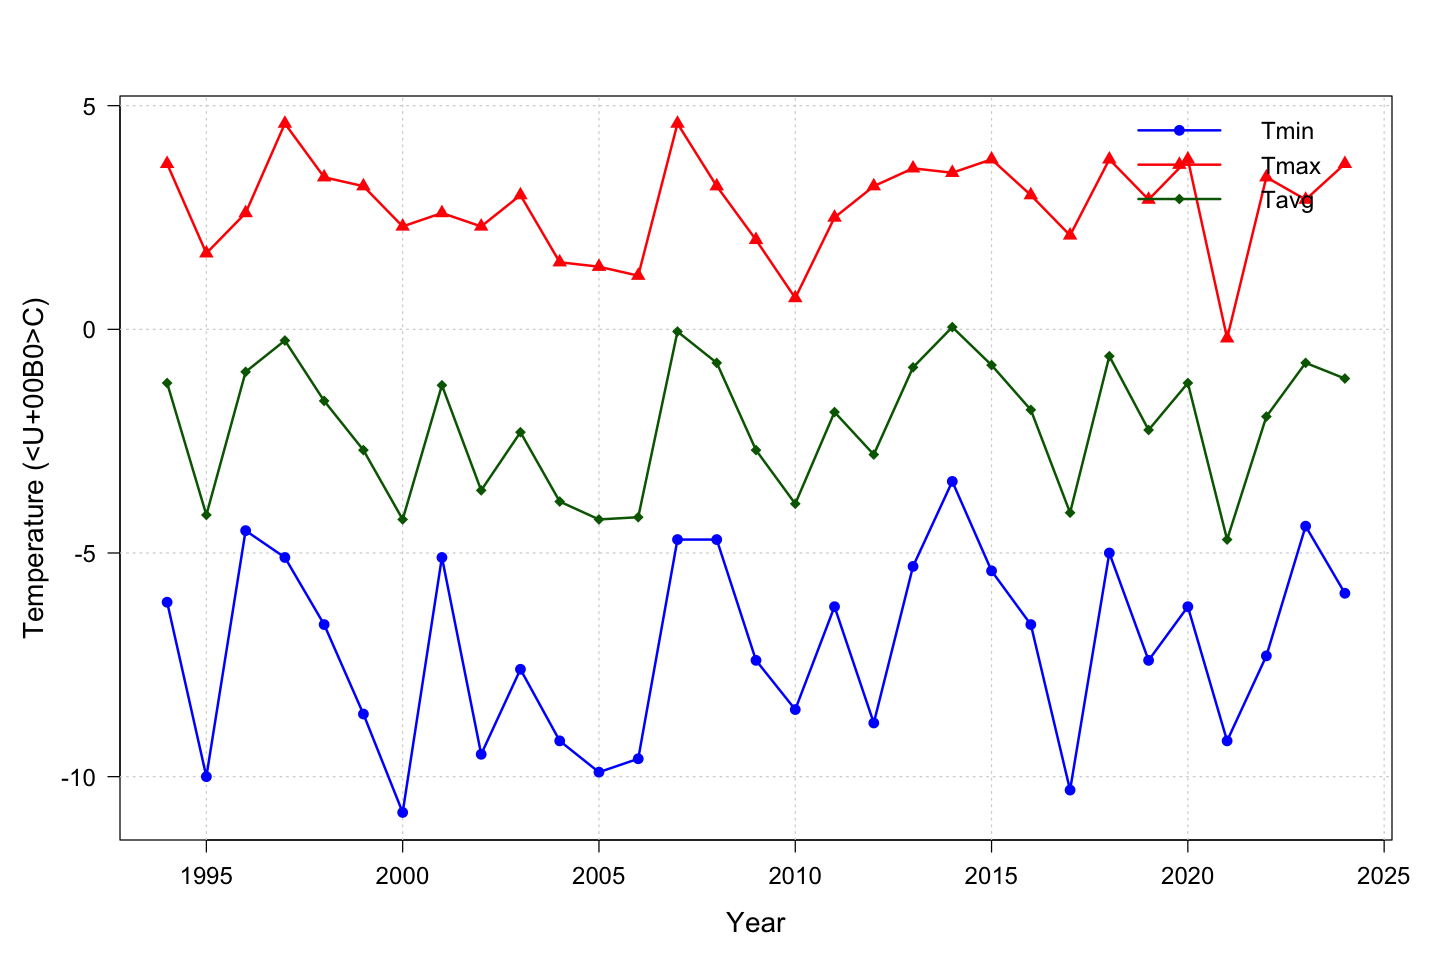

In [22]:
# Cambia size dell'immagine
options(repr.plot.width=12, repr.plot.height=8)

Tmin_gen <- dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle minime"]][,"GEN"]
Tmax_gen <- dataset[["Auronzo"]][["Temperatura aria a 2m (_C) media delle massime"]][,"GEN"]
Tmean_gen <- (Tmin_gen+Tmax_gen)/2

Tmin_gen <- suppressWarnings(as.numeric(Tmin_gen))
Tmax_gen <- suppressWarnings(as.numeric(Tmax_gen))

n <- min(length(Tmin_gen), length(Tmax_gen))
Tmin_gen <- Tmin_gen[1:n]
Tmax_gen <- Tmax_gen[1:n]
years <- 1994:(1994 + n - 1)

valid_idx <- !is.na(Tmin_gen) & !is.na(Tmax_gen)
years <- years[valid_idx]
Tmin_gen <- Tmin_gen[valid_idx]
Tmax_gen <- Tmax_gen[valid_idx]

# Imposta margini e dimensioni del testo
par(mar = c(5, 5, 4, 2), cex.axis = 1.2, cex.lab = 1.4, cex.main = 1.5, bg = "white")

# Plot vuoto con più spazio e più grande
plot(years, Tmin_gen, type = "n", 
     ylim = range(c(Tmin_gen, Tmax_gen)), 
     xlab = "Year", ylab = "Temperature (°C)", 
     las = 1, cex = 1.2, cex.lab = 1.4, cex.axis = 1.2)

# Aggiungi griglia leggera
grid(col = "lightgray", lty = "dotted")

# Linee
lines(years, Tmin_gen, col = "blue", lwd = 2)
lines(years, Tmax_gen, col = "red", lwd = 2)
lines(years, Tmean_gen, col = "darkgreen", lwd = 2)

# Punti
points(years, Tmin_gen, col = "blue", pch = 16, cex = 1.2)
points(years, Tmax_gen, col = "red", pch = 17, cex = 1.2)
points(years, Tmean_gen, col = "darkgreen", pch = 18, cex = 1.2)

# Legenda migliorata
legend("topright", legend = c("Tmin", "Tmax", "Tavg"),
       col = c("blue", "red", "darkgreen"), 
       lty = 1, pch = c(16, 17, 18),
       lwd = 2, bty = "n", cex = 1.2)

# Part 1

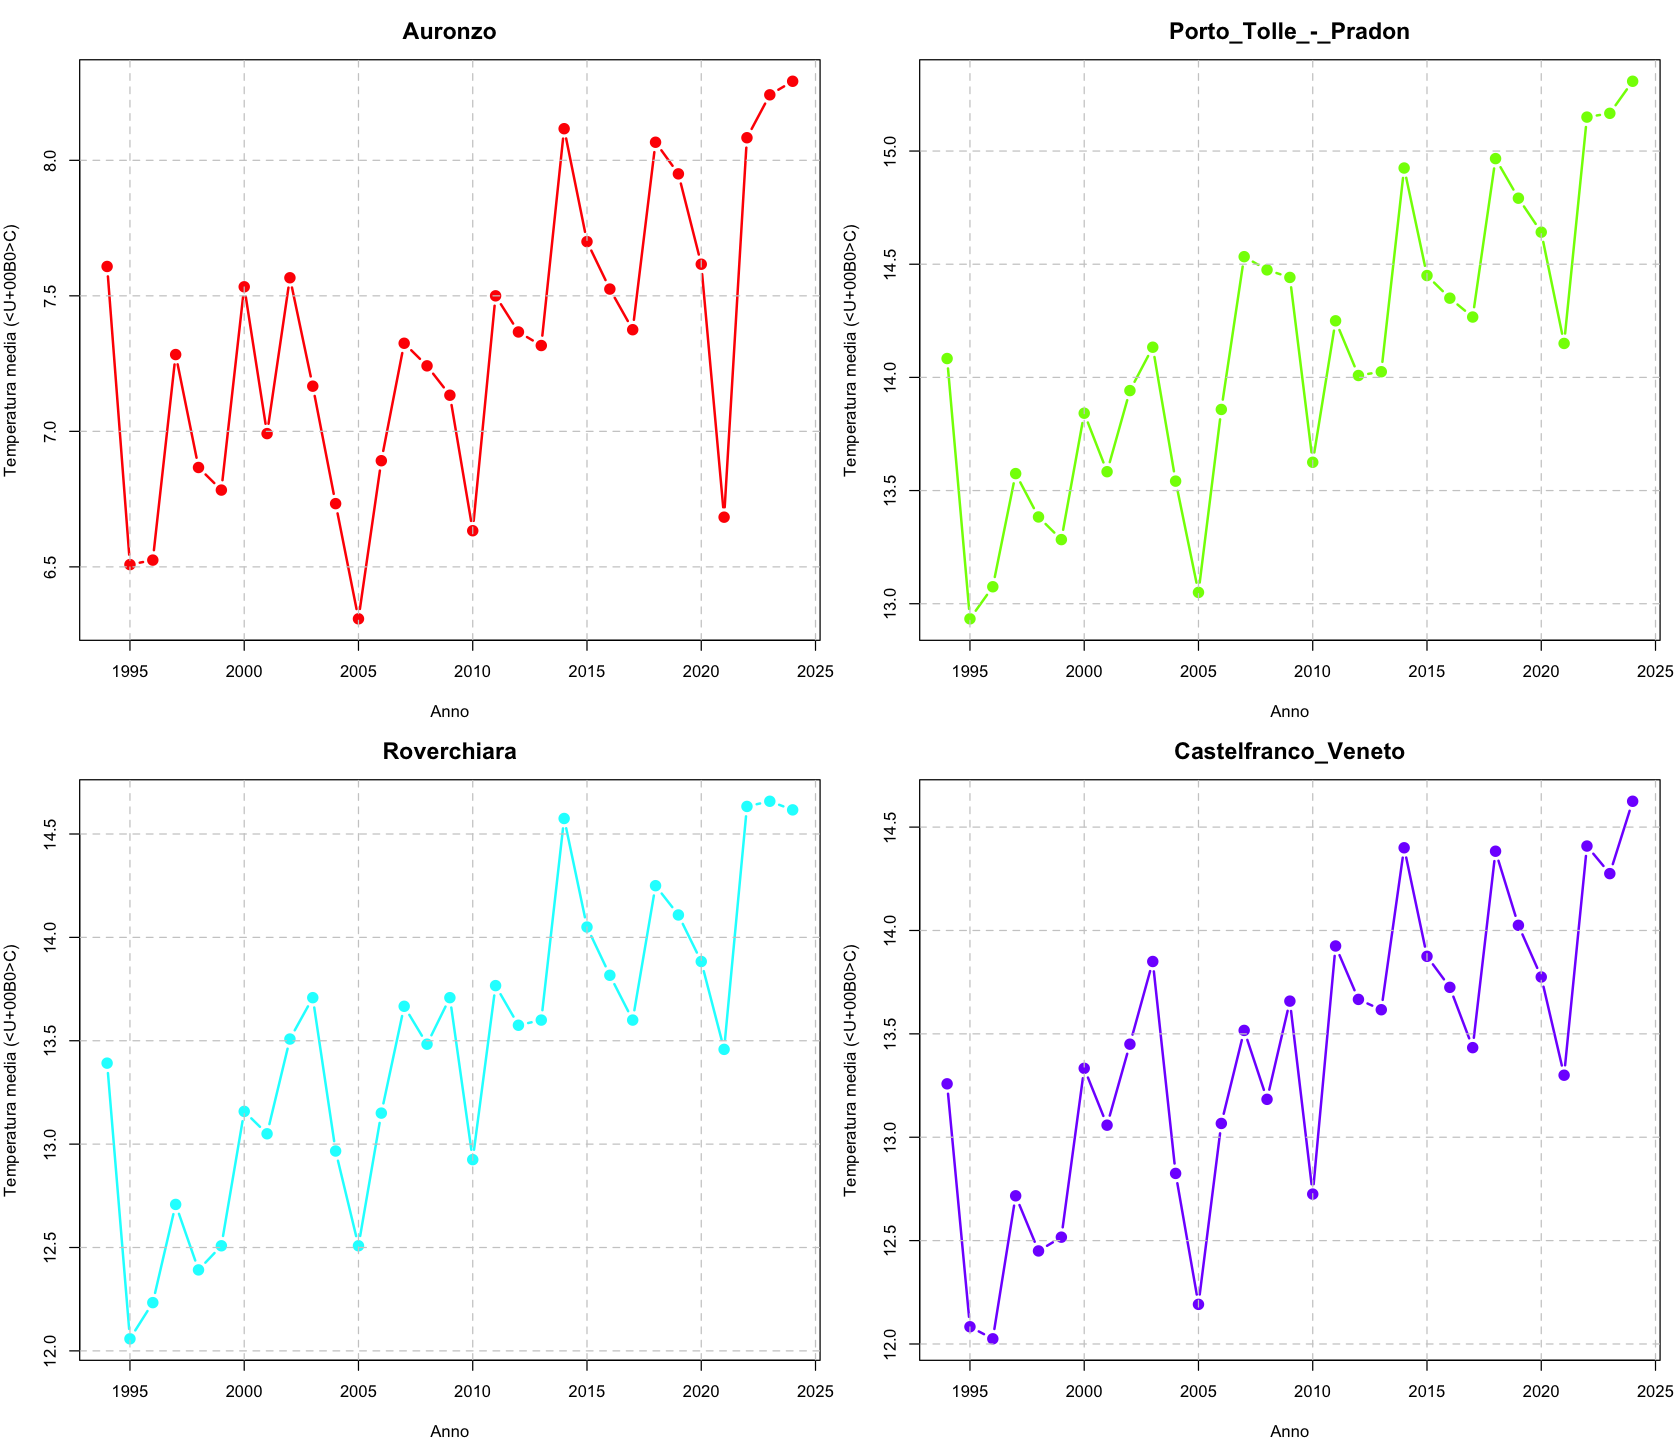

In [17]:
options(repr.plot.width=14, repr.plot.height=12)

years <- 1994:2024
par(mfrow = c(2,2), bg = "white", mar=c(4,4,3,1))  # margini migliorati

# Palette di colori piacevole
colors <- rainbow(length(stations_names))

for (i in seq_along(stations_names)) {
    name <- stations_names[i]
    
    # Calcolo media annuale
    annual_average <- rowMeans(dataset[[name]][["Temperatura aria a 2m (_C) media delle medie"]])
    
    # Plot migliorato
    plot(years, annual_average, type="b", pch=19, col=colors[i],
         lwd=2, cex=1.2,
         main=name, font.main=2, cex.main=1.4,
         xlab="Anno", ylab="Temperatura media (°C)")
    
    grid(col="gray80", lty=2)  # aggiunge griglia leggera
}
